# Timeseries tutorial

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
timeseries_path = os.path.join('..', 'pvops', 'timeseries')
sys.path.append('..')
sys.path.append(timeseries_path)

In [3]:
from pvops.timeseries import preprocess
from pvops.timeseries.models import linear, iec, AIT
from pvops.text2time import utils as t2t_utils, preprocess as t2t_preprocess

In [4]:
example_OMpath = os.path.join('example_data', 'example_om_data2.csv')
example_prodpath = os.path.join('example_data', 'example_prod_with_covariates.csv')
example_metapath = os.path.join('example_data', 'example_metadata2.csv')

In [5]:
prod_data = pd.read_csv(example_prodpath, error_bad_lines=False, engine='python')

In [6]:
prod_data.head()

,date,randid,generated_kW,expected_kW,irrad_poa_Wm2,temp_amb_C,wind_speed_ms,temp_mod_C
0,2018-04-01 07:00:00,R15,0.475,0.527845,0.02775,16.570,4.2065,14.1270
1,2018-04-01 08:00:00,R15,1332.547,1685.979445,87.91450,16.998,4.1065,15.8610
2,2018-04-01 09:00:00,R15,6616.573,7343.981135,367.90350,20.168,4.5095,24.5745
3,2018-04-01 10:00:00,R15,8847.800,10429.876422,508.28700,21.987,4.9785,30.7740
4,2018-04-01 11:00:00,R15,11607.389,12981.228814,618.79450,23.417,4.6410,35.8695


In [7]:
metadata = pd.DataFrame()
metadata['randid'] = ['R15', 'R10']
metadata['dcsize'] = [25000, 25000]
metadata.head()

,randid,dcsize
0,R15,25000
1,R10,25000


In [8]:
#Format for dictionaries is {pvops variable: user-specific column names}
prod_col_dict = {'siteid': 'randid', 
                 'timestamp': 'date', 
                 'powerprod': 'generated_kW',
                 'energyprod': 'generated_kW',
                 'irradiance':'irrad_poa_Wm2',
                 'temperature':'temp_amb_C', # Optional parameter, used by one of the modeling structures
                 'baseline': 'AIT', #user's name choice for new column (baseline expected energy defined by user or calculated based on IEC)
                 'dcsize': 'dcsize', #user's name choice for new column (System DC-size, extracted from meta-data)
                 'compared': 'Compared',#user's name choice for new column
                 'energy_pstep': 'Energy_pstep', #user's name choice for new column
                 'capacity_normalized_power': 'capacity_normalized_power', #user's name choice for new column
}

metad_col_dict = {'siteid': 'randid',
                  'dcsize': 'dcsize'}

### Data Formatting

In [9]:
prod_data_converted = t2t_preprocess.prod_date_convert(prod_data, prod_col_dict)
prod_data_datena_d, _ = t2t_preprocess.prod_nadate_process(prod_data_converted, prod_col_dict, pnadrop=True)

In [10]:
prod_data_datena_d.index = prod_data_datena_d[prod_col_dict['timestamp']]

min(prod_data_datena_d.index), max(prod_data_datena_d.index)

(Timestamp('2018-04-01 07:00:00'), Timestamp('2019-03-31 18:00:00'))

### Data Preprocessing

In [11]:
masked_prod_data = preprocess.prod_inverter_clipping_filter(prod_data_datena_d, prod_col_dict, metadata, metad_col_dict, 'threshold', freq=60)

filtered_prod_data = masked_prod_data[masked_prod_data['mask'] == False]
del filtered_prod_data['mask']

print(f"Detected and removed {sum(masked_prod_data['mask'])} rows with inverter clipping.")

Detected and removed 24 rows with inverter clipping.


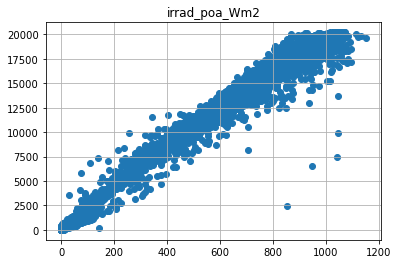

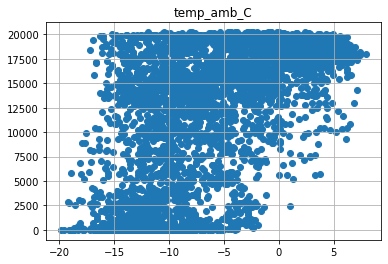

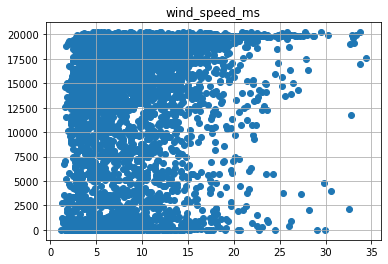

In [12]:
# Visualize the power signal versus covariates for one site
temp = filtered_prod_data[filtered_prod_data['randid'] == 'R10']
for xcol in ['irrad_poa_Wm2', 'temp_amb_C', 'wind_speed_ms']:
    plt.scatter(temp[xcol], temp[prod_col_dict['powerprod']])
    plt.title(xcol)
    plt.grid()
    plt.show()

In [13]:
# Add a dcsize column
filtered_prod_data[prod_col_dict['dcsize']] = filtered_prod_data.loc[:, prod_col_dict['siteid']]

metad = metadata.copy()
metad.index = metad['randid']
del metad['randid']

filtered_prod_data.replace(metad.to_dict(), inplace=True)

C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


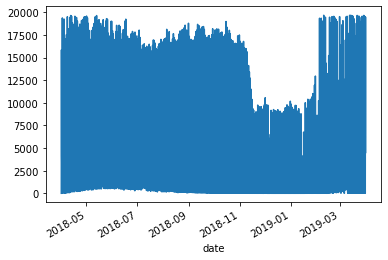

In [14]:
filtered_prod_data[filtered_prod_data['randid'] == 'R15'][prod_col_dict['energyprod']].plot()

In [15]:
model_prod_data = filtered_prod_data.dropna(subset=['irrad_poa_Wm2', 'temp_amb_C', 'wind_speed_ms', 'dcsize']+[prod_col_dict['energyprod']])
model_prod_data

,date,randid,generated_kW,expected_kW,irrad_poa_Wm2,temp_amb_C,wind_speed_ms,temp_mod_C,dcsize
date,,,,,,,,,
2018-04-01 07:00:00,2018-04-01 07:00:00,R15,0.475,0.527845,0.02775,16.570000,4.2065,14.127000,25000
2018-04-01 08:00:00,2018-04-01 08:00:00,R15,1332.547,1685.979445,87.91450,16.998000,4.1065,15.861000,25000
2018-04-01 09:00:00,2018-04-01 09:00:00,R15,6616.573,7343.981135,367.90350,20.168000,4.5095,24.574500,25000
2018-04-01 10:00:00,2018-04-01 10:00:00,R15,8847.800,10429.876422,508.28700,21.987000,4.9785,30.774000,25000
2018-04-01 11:00:00,2018-04-01 11:00:00,R15,11607.389,12981.228814,618.79450,23.417000,4.6410,35.869500,25000
...,...,...,...,...,...,...,...,...,...
2019-03-31 14:00:00,2019-03-31 14:00:00,R10,19616.000,20179.797303,967.10350,-4.129722,5.9935,35.860694,25000
2019-03-31 15:00:00,2019-03-31 15:00:00,R10,19552.000,20149.254116,983.94500,-4.214444,5.1770,38.549306,25000
2019-03-31 16:00:00,2019-03-31 16:00:00,R10,19520.000,20192.672439,1011.77950,-3.943611,4.2430,42.848889,25000


## Dynamic linear modeling

In [16]:
model_prod_data = AIT.AIT_calc(model_prod_data, prod_col_dict)

The fit has an R-squared of -569972861.7979063 and a log RMSE of 9.515344605202777


In [32]:
def plot(data, randid, from_idx=0, to_idx=1000):
    data.copy()
    # Just making the visualization labels better here.. for this example's data specifically.
    data.rename(columns={'generated_kW': 'Measured Energy',
                         'AIT': 'Our Pre-trained Model',
                         'expected_kW': 'Partner Expected Energy'}, inplace=True)
    data[data['randid']==randid][['Measured Energy', 'Our Pre-trained Model', 'Partner Expected Energy']].iloc[from_idx:to_idx].plot(figsize=(12,6))

## Visualize results

We visualize the measured hourly energy, our pre-trained model's expected energy, and the results of a partner-produced expected energy.

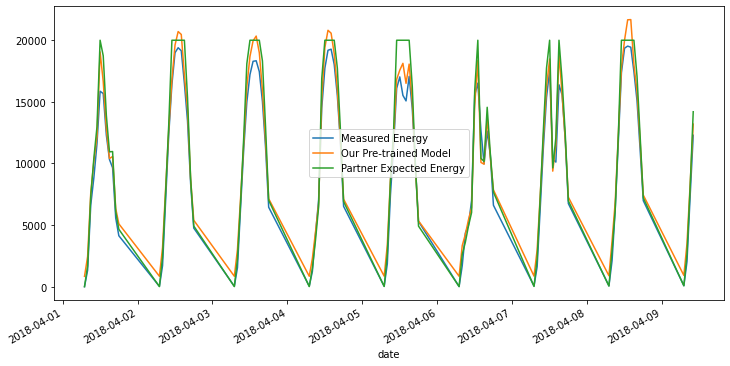

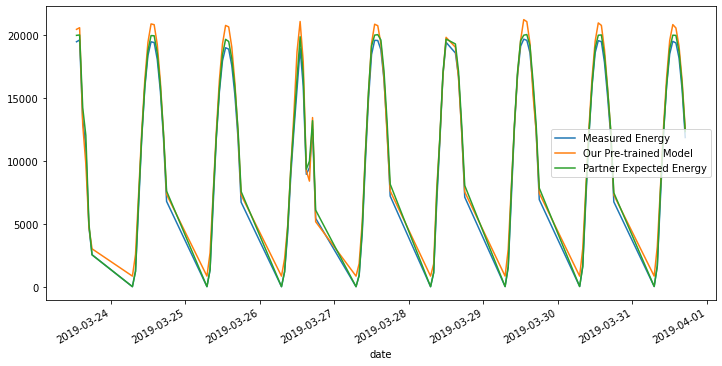

In [33]:
plot(model_prod_data, "R15", from_idx=0, to_idx=100)
plot(model_prod_data, "R15", from_idx=-100, to_idx=-1)

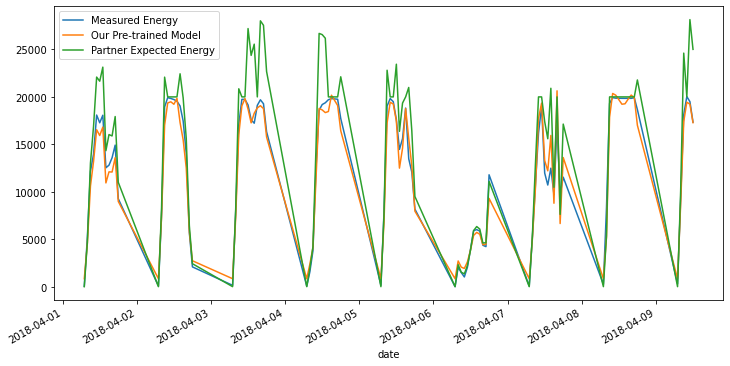

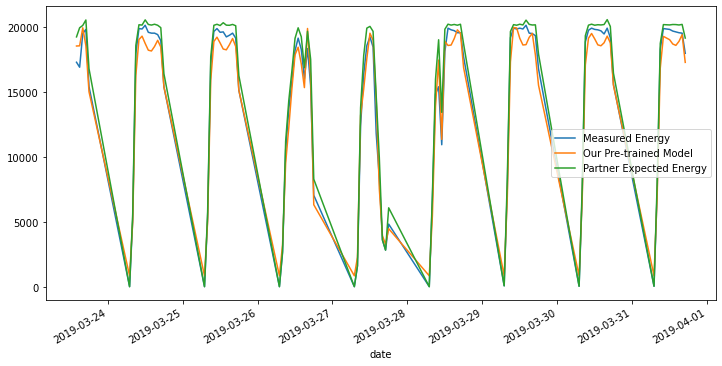

In [34]:
plot(model_prod_data, "R10", from_idx=0, to_idx=100)
plot(model_prod_data, "R10", from_idx=-100, to_idx=-1)

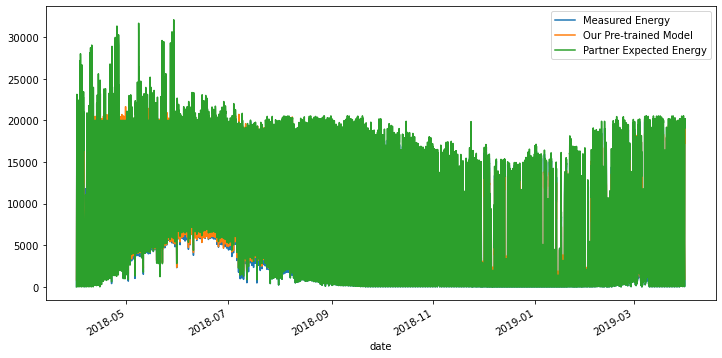

In [35]:
plot(model_prod_data, "R10", from_idx=0, to_idx=-1)